## edgeR TMM-Normalization with mRNA counts table

In [1]:
options(stringsAsFactors = FALSE)

In [5]:
#Load packages
library(limma)
library(edgeR)
library(data.table)
#library(Glimma)
#library(affycoretools)
library(RColorBrewer)
library(gplots)
library(ggplot2)
library(biomaRt)
library(apeglm)
library(DESeq2)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:limma’:

    plotMA


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min




ERROR: Error in value[[3L]](cond): Package ‘S4Vectors’ version 0.36.1 cannot be unloaded:
 Error in unloadNamespace(package) : namespace ‘S4Vectors’ is imported by ‘IRanges’, ‘AnnotationDbi’, ‘GenomicRanges’, ‘Biostrings’, ‘SummarizedExperiment’, ‘XVector’, ‘DelayedArray’, ‘GenomeInfoDb’ so cannot be unloaded



### Creating DGE object for edgeR

In [6]:
#Read in count data and metadata
meta <- read.csv("metadata.csv", stringsAsFactors=F)
counts <- read.csv("featCounts_mouse_E18.csv", stringsAsFactors=F, row.names=1)
head(meta)
head(counts)

,Sample_ID,Group
,<chr>,<chr>
1,E18_KO_1,KO
2,E18_KO_2,KO
3,E18_KO_3,KO
4,E18_WT_2,WT
5,E18_WT_3,WT
6,E18_WT_4,WT


,E18_Double_KO_1,E18_Double_KO_2,E18_Double_KO_3,E18_WT_2,E18_WT_3,E18_WT_4
,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000102693,0,0,1,0,1,1
ENSMUSG00000064842,0,0,0,0,0,0
ENSMUSG00000051951,2,10,3,0,0,2
ENSMUSG00000102851,0,0,0,0,0,0
ENSMUSG00000103377,0,0,0,0,0,0
ENSMUSG00000104017,0,0,0,0,0,0


Make DGE object: Define groups and design

In [7]:
#define DGE list
#define groups
group<-meta$Group
group
design <- model.matrix(~0+group)
dge<- DGEList(counts=counts,group=group)

[1] "KO" "KO" "KO" "WT" "WT" "WT"

Plot library sizes

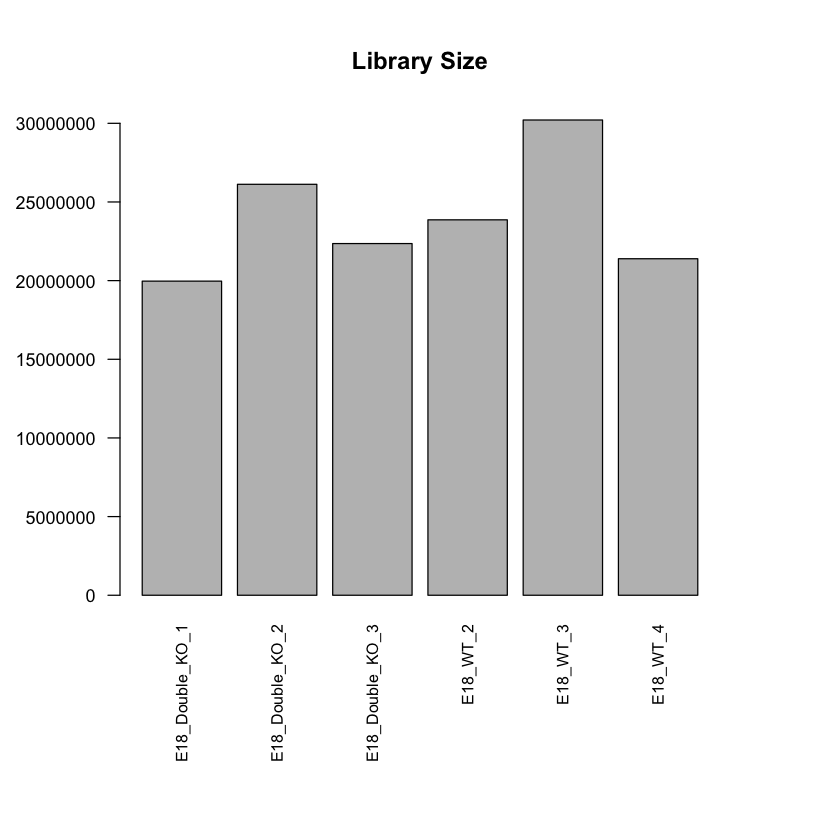

In [8]:
#lib sizes
par(mar=c(10,5,5,5))
options(scipen=5)
barplot(dge$samples$lib.size, horiz=F, names.arg=colnames(dge$counts), las=2, cex.name = 0.8, cex.axis=.9, main="Library Size")

In [9]:
#To check
class(dge)
dim(dge)
dge$samples

[1] "DGEList"
attr(,"package")
[1] "edgeR"

[1] 48795     6

,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
E18_Double_KO_1,KO,19967593,1
E18_Double_KO_2,KO,26123103,1
E18_Double_KO_3,KO,22356289,1
E18_WT_2,WT,23864118,1
E18_WT_3,WT,30210498,1
E18_WT_4,WT,21391109,1


### Filtering based on cpm cutoff 

In [10]:
#filter
table(rowSums(dge$counts==0)==6)
keep <- rowSums(cpm(dge)>10) >= 3
dge.f <- dge[keep, , keep.lib.sizes=FALSE]
dim(dge.f)


FALSE  TRUE 
28339 20456 

[1] 10397     6

### Estimate dispersion

The square root of the common dispersion gives the coefficient of variation of biological variation. The dispersion estimates can be viewed in a BCV plot.

In [11]:
#estimate dispersions
d <- estimateDisp(dge.f, design=design)
d$samples$lib.size
summary(d$prior.df)
sqrt(d$common.disp)

[1] 19573378 25612850 21955288 23309523 29496507 20737249

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  4.201   4.201   4.201   4.201   4.201   4.201 

[1] 0.2466776

### Normalization using TMM
“TMM (weighted trimmed mean of log expression) determines scaling factor calculated after double trimming values at the two extremes based on log-intensity ratios (M-values) and log-intensity averages (A-values)” (Dillies et al. Briefings in Bioinformatics, Vol. 14 (6): 671–683, 2013)

Calculate log cpm to plot graphs using TMM normalized counts

In [12]:
#cpm, log cpm using TMM
cpm <- cpm(dge)
lcpm <- cpm(dge, log=TRUE)
dge.norm <- calcNormFactors(d,method="TMM") 
dge.norm$samples$norm.factors
lcpm.norm <- cpm(dge.norm, log=TRUE)

[1] 0.9239004 0.9324555 0.8274117 1.1162659 1.1195522 1.1225691

## Plots

### Filtered and unfiltered data 

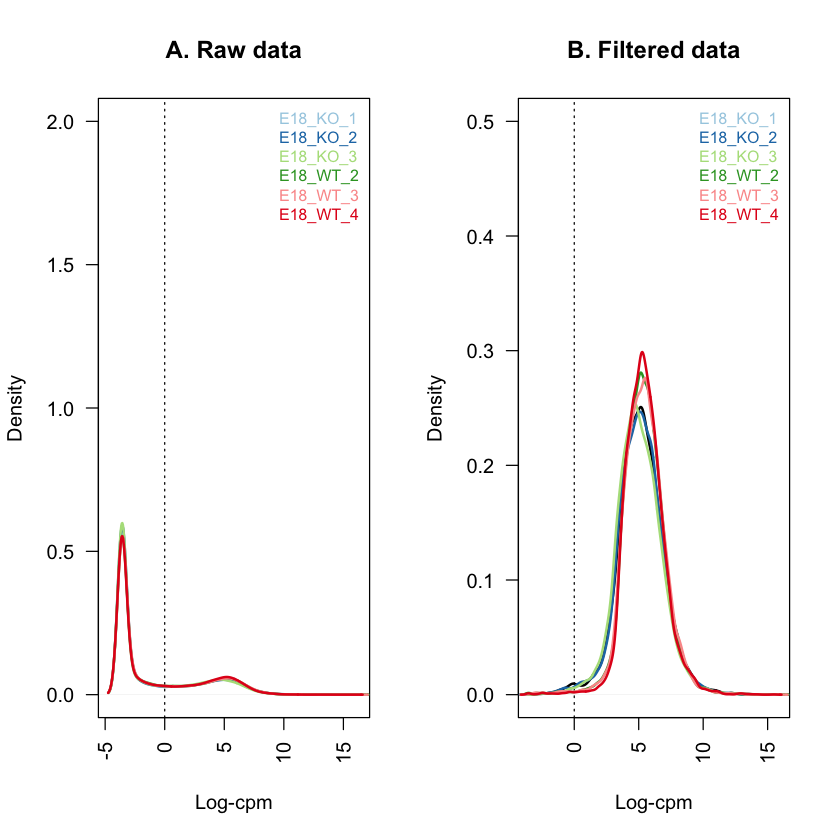

In [13]:
#set colours for graphs
nsamples<-ncol(dge.norm)
col <- brewer.pal(nsamples, "Paired")

#Visualise filtered vs unfiltered data
#plot unfiltered data
samplenames<-meta$Sample_ID
par(mfrow=c(1,2))
plot(density(lcpm[,1]),col=col(lcpm,as.factor = FALSE),lwd=1,ylim=c(0,2),las=2,main="",xlab="")
title(main="A. Raw data", xlab="Log-cpm")
abline(v=0, lty=3)
for (i in 2:nsamples){
  den <- density(lcpm[,i])
  lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", samplenames, text.col=col, bty="n",cex=0.8,pt.cex=0.8)

#plot filtered data
lcpm.f <- cpm(dge.f, log=TRUE)
plot(density(lcpm.f[,1]), col=col(lcpm.f,as.factor=FALSE), lwd=2, ylim=c(0,0.5), las=2,
     main="", xlab="")
title(main="B. Filtered data", xlab="Log-cpm")
abline(v=0, lty=3)
for (i in 2:nsamples){
  den <- density(lcpm.f[,i])
  lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", samplenames, text.col=col, bty="n",cex=0.8,pt.cex=0.8)


### Boxplots of TMM-Normalized vs. unnormalized data

[1] 1 1 1 1 1 1

[1] 0.9239004 0.9324555 0.8274117 1.1162659 1.1195522 1.1225691

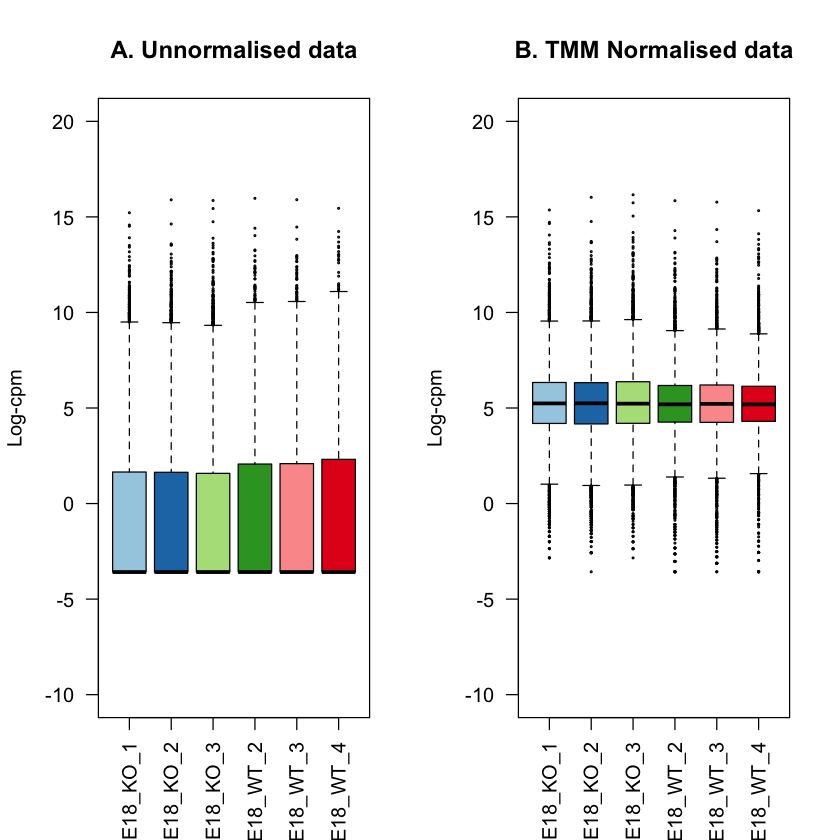

In [14]:
#Visualise normalised data
par(mfrow=c(1,2))
lcpm <- cpm(dge, log=TRUE)
dge$samples$norm.factors
boxplot(lcpm,las=2, col=col, main="",ylim=c(-10,20),names=meta$Sample_ID,cex=0.2)
title(main="A. Unnormalised data",ylab="Log-cpm")

dge.norm$samples$norm.factors
lcpm.norm <- cpm(dge.norm, log=TRUE)
boxplot(lcpm.norm, las=2, col=col, main="", ylim=c(-10,20),names=meta$Sample_ID,cex=0.2)
title(main="B. TMM Normalised data",ylab="Log-cpm")

### PCA plot

[1] 2

Warning message in brewer.pal(nlevels(col.1), "Paired"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


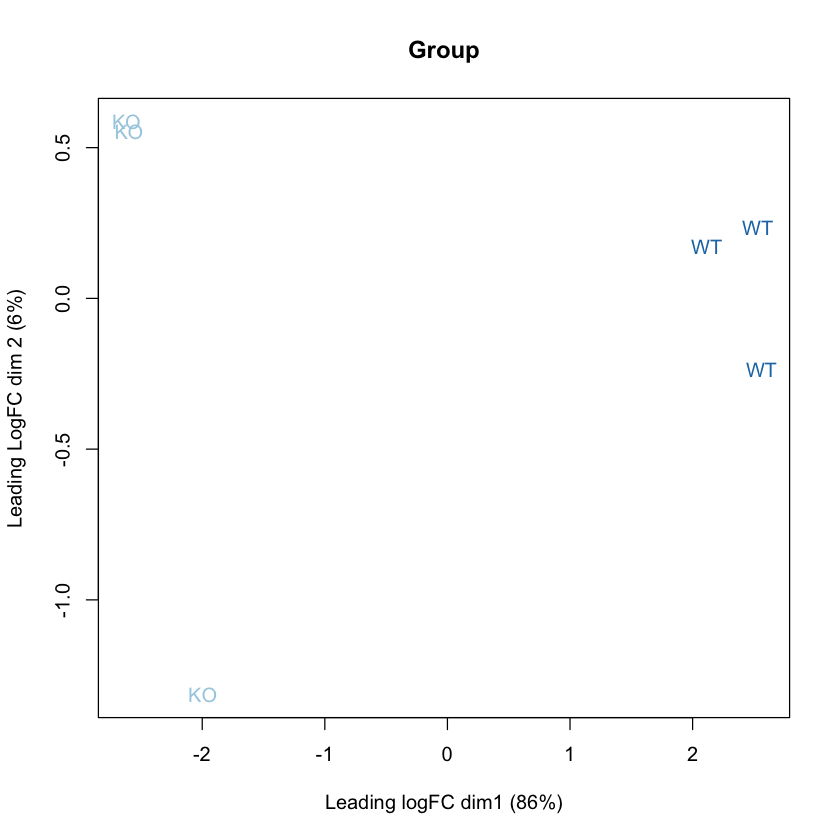

In [15]:
#MDS Plots
lcpm.norm <- cpm(dge.norm, log=TRUE)
Group <- as.factor(meta$Group)
col.1 <- Group
char.1 <- Group
nlevels(col.1)

levels(col.1) <-  brewer.pal(nlevels(col.1), "Paired") #if more than 2 conditions
col.1 <- as.character(col.1)
levels(char.1) <- c(0:nlevels(char.1))

plotMDS(lcpm.norm,top = 500, labels=meta$Group, col=col.1, cex=1, pch=19,xlab="Leading logFC dim1", ylab="Leading LogFC dim 2")
title(main="Group")

## Limma-voom

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4937821/

### Removing heteroscedascity from count data

It has been shown that for RNA-seq count data, the variance is not independent of the mean – this is true of raw counts or when transformed to log-CPM values. Methods that model counts using a Negative Binomial distribution assume a quadratic mean-variance relationship. In limma, linear modelling is carried out on the log-CPM values which are assumed to be normally distributed and the mean-variance relationship is accommodated using precision weights calculated by the voom function.

When operating on a DGEList-object, voom converts raw counts to log-CPM values by automatically extracting library sizes and normalisation factors from x itself. 

Typically, the “voom-plot” shows a decreasing trend between the means and variances resulting from a combination of technical variation in the sequencing experiment and biological variation amongst the replicate samples from different cell populations. Experiments with high biological variation usually result in flatter trends, where variance values plateau at high expression values. Experiments with low biological variation tend to result in sharp decreasing trends.

In [16]:
#limma-voom 
#Set up design
#limma-voom 
#Set up design
design <- model.matrix(~0 + group)
colnames(design) <- gsub("group","", colnames(design))
design

,KO,WT
1,1,0
2,1,0
3,1,0
4,0,1
5,0,1
6,0,1


In [17]:
cm <- makeContrasts(WTvsKO=WT-KO,levels=design)

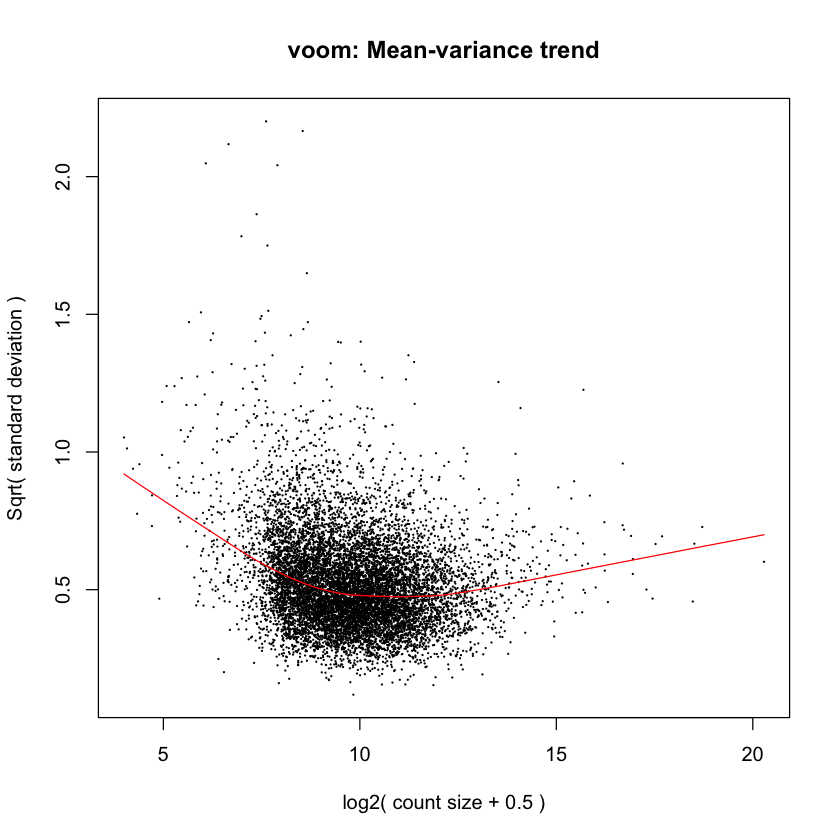

In [18]:
#Apply voom to remove heteroscedasticity from count data
v <- voom(dge.norm, design, plot=TRUE)
write.csv(v$E, "TMM_and_Voom_normalized_counts.csv")

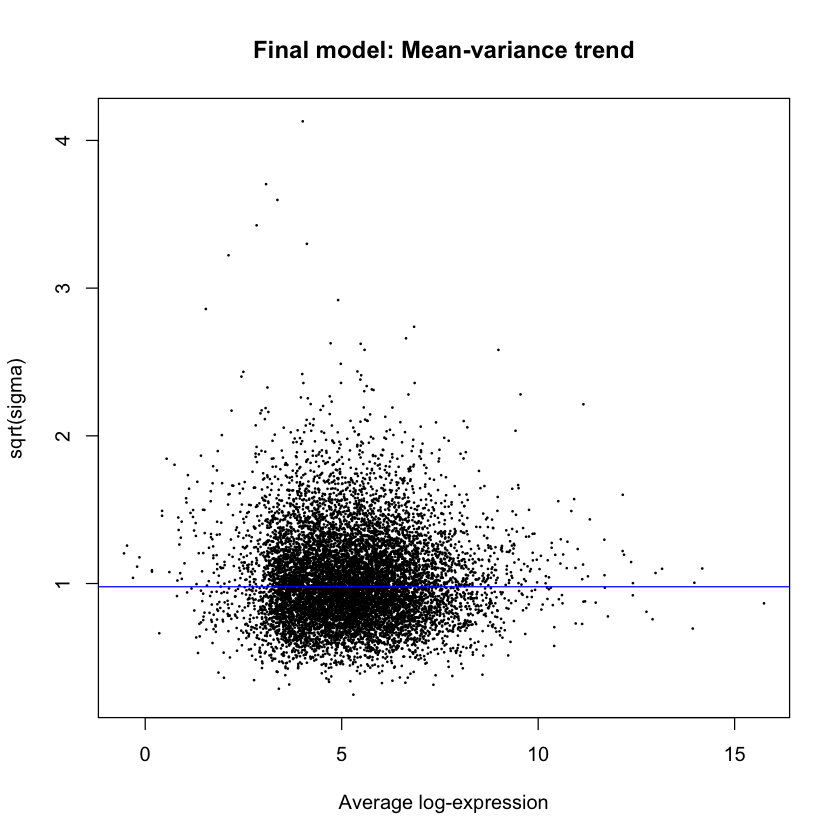

In [19]:
#Fit linear model
#pdf("Final model: Mean-variance trend_dge.pdf")
vfit <- lmFit(v,design)
vfit <- contrasts.fit(vfit, contrasts=cm)
efit <- eBayes(vfit)
plotSA(efit, main="Final model: Mean-variance trend")

In [20]:
dt <- decideTests(efit)
summary(dt)

       WTvsKO
Down     2788
NotSig   4966
Up       2643

### mRNAs with p<0.01

In [21]:
#write out p0.01 RNAs
WT_vs_KO<-topTreat(efit,coef=1,n=Inf)
head(WT_vs_KO)
ENSID<-row.names(WT_vs_KO)
norm<-data.frame(v$E)
merged<-merge(WT_vs_KO,norm,by=0,all=TRUE)
final<-subset(merged,merged$adj.P.Val<0.01)
write.table(final,file="final_mRNAs_p0.01.txt",sep="\t")

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000052187,8.746585,8.168015,40.23910,2.973118e-10,0.000003091151,12.679659
ENSMUSG00000056025,-6.293124,7.553382,-30.48654,2.504650e-09,0.000009776333,11.898528
ENSMUSG00000041608,-6.080431,6.078818,-28.78323,3.890882e-09,0.000009776333,11.447727
ENSMUSG00000055609,8.022010,5.892712,28.28785,4.444042e-09,0.000009776333,10.555818
ENSMUSG00000063522,-10.319850,5.246369,-28.08050,4.701516e-09,0.000009776333,9.601061
ENSMUSG00000020027,-5.213185,5.690759,-26.24224,7.891957e-09,0.000013675445,10.945453


### Heatmap with mRNAs with p<0.01

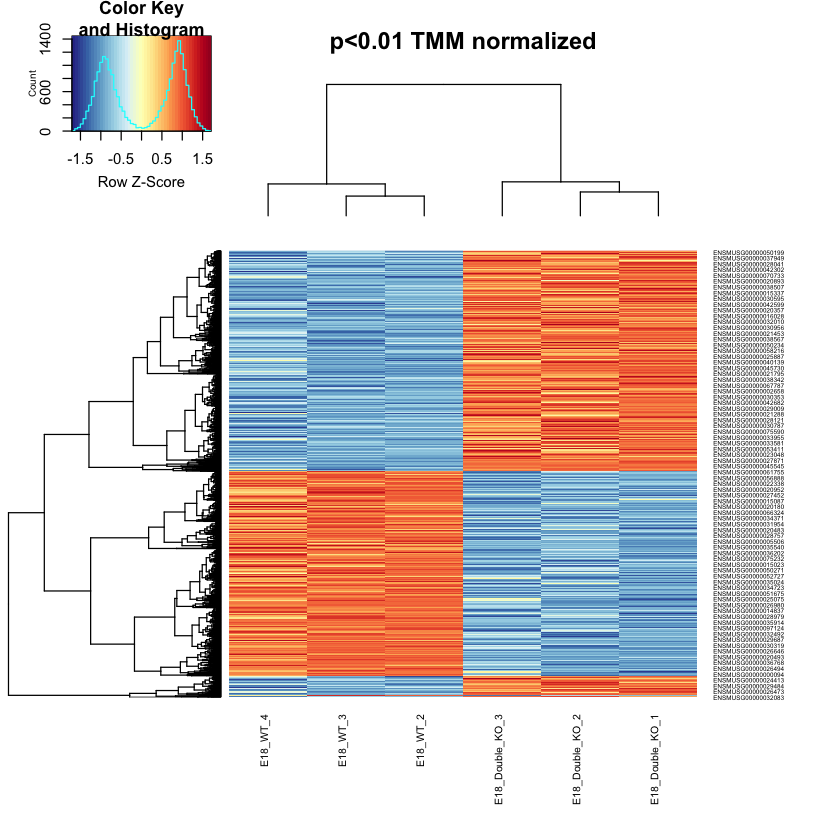

In [22]:
#heatmap
#subset miRNAs from lcpm normalized data
mRNAs<-as.list(final$Row.names)
lcpm.norm.heatmap<-as.matrix(subset(norm,rownames(norm) %in% mRNAs))

## Get some nicer colours
mypalette <- brewer.pal(11,"RdYlBu")
morecols <- colorRampPalette(mypalette)
# Set up colour vector for celltype variable
col.cell <- c("purple","orange")[group]
heatmap.2(lcpm.norm.heatmap,col=rev(morecols(50)),trace="none", main="p<0.01 TMM normalized",ColSideColors=col.cell,scale="row",margins=c(9,9), cexCol=0.8)

### Biomart to get gene information from ENSEMBL IDs

In [23]:
#biomart
ENSID<-final$Row.names
genes<-ENSID
mart <- useDataset("mmusculus_gene_ensembl", useMart("ensembl"))
attributes<-listAttributes(mart)
G_list <- data.table(getBM(filters= "ensembl_gene_id", attributes= c("ensembl_gene_id", "description","uniprot_gn_symbol"),values=genes,mart= mart))
write.table(G_list,file="biomart_genes_list_edgeR.txt",sep="\t")

### Heatmap with top 50 dysregulated mRNAs with gene names

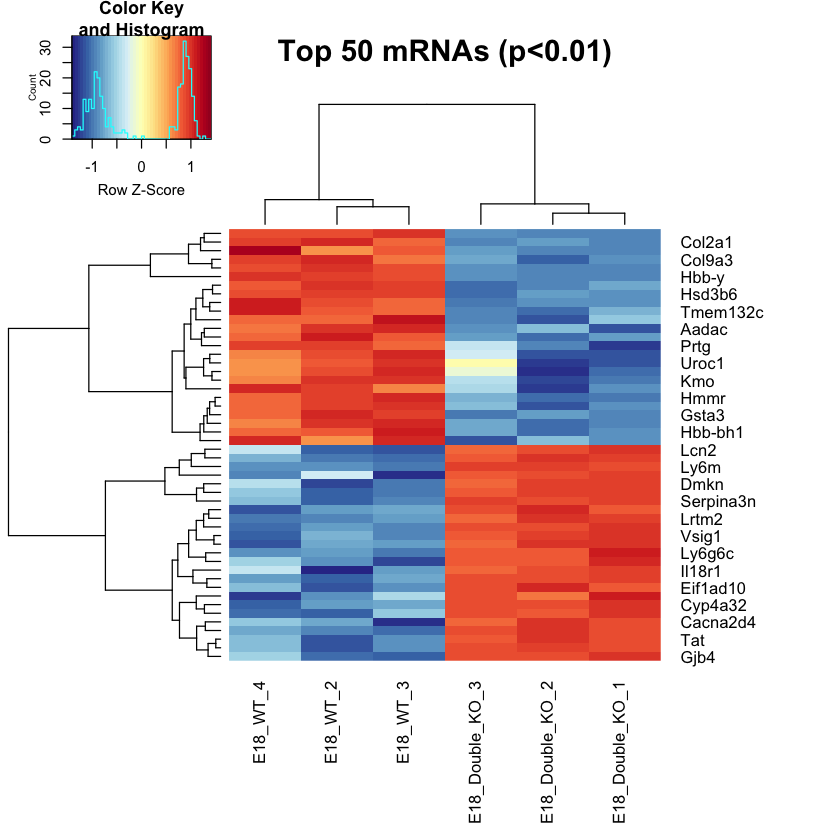

In [24]:
top50<-as.matrix(read.delim("top50_edgeR.txt",header=TRUE,row.names=1))
mypalette <- brewer.pal(11,"RdYlBu")
morecols <- colorRampPalette(mypalette)
heatmap.2(top50,col=rev(morecols(50)),trace="none", main="Top 50 mRNAs (p<0.01)",scale="row",margins=c(9,9), cexCol=1,cexRow=1)